In [2]:
#Install Dependencies
import os.path
import pandas as pd
import random
import math
import numpy as np
from scipy import stats, linalg
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse, Polygon
from distfit import distfit

In [3]:
#Read dfs_forecast data
current_path = os.getcwd()
udfs_data_path = os.path.dirname(current_path) + "\Data\\udfs_data2021.csv"
udfs_data = pd.read_csv(udfs_data_path)

#Remove players who did not play
udfs_data = udfs_data.loc[(udfs_data["DK points"] != 0) | (udfs_data["Pos"] == "DST")]
udfs_data

,Year,Week,Name,Pos,Team,ProjDKPts,ProjFDPts,Team2,Oppt,DK points,DK salary,error
0,2021,1,Christian McCaffrey,RB,Panthers,23.34,19.86,car,nyj,27.70,9500,4.36
1,2021,1,Dalvin Cook,RB,Vikings,22.18,19.15,min,cin,21.40,9100,-0.78
2,2021,1,Derrick Henry,RB,Titans,19.99,17.60,ten,ari,10.70,8800,-9.29
3,2021,1,Jonathan Taylor,RB,Colts,15.65,13.84,ind,sea,17.60,8000,1.95
4,2021,1,Calvin Ridley,WR,Falcons,20.38,15.99,atl,phi,10.10,7900,-10.28
...,...,...,...,...,...,...,...,...,...,...,...,...
17850,2021,18,Mekhi Sargent,RB,Jaguars,0.00,0.00,jac,ind,0.20,4000,0.20
17927,2021,18,Dazz Newsome,WR,Bears,0.00,0.00,chi,min,2.30,3000,2.30
18001,2021,18,Mitchell Trubisky,QB,Bills,0.00,0.00,buf,nyj,0.30,5000,0.30
18009,2021,18,Trevor Siemian,QB,Saints,0.00,0.00,nor,atl,10.74,4600,10.74


[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.0 sec] [RSS: 0.00364366] [loc=0.687 scale=6.697]
[distfit] >[expon     ] [0.0 sec] [RSS: 0.0325631] [loc=-22.230 scale=22.917]
[distfit] >[pareto    ] [0.22 sec] [RSS: 0.0326805] [loc=-1574063455.941 scale=1574063433.711]
[distfit] >[dweibull  ] [0.05 sec] [RSS: 0.000875623] [loc=0.132 scale=4.977]
[distfit] >[t         ] [0.08 sec] [RSS: 0.00151762] [loc=0.138 scale=5.128]
[distfit] >[genextreme] [0.26 sec] [RSS: 0.00280737] [loc=-2.088 scale=6.040]
[distfit] >[gamma     ] [0.05 sec] [RSS: 0.00273348] [loc=-32.397 scale=1.319]
[distfit] >[lognorm   ] [0.09 sec] [RSS: 0.0026067] [loc=-42.312 scale=42.496]
[distfit] >[beta      ] [0.16 sec] [RSS: 0.00281217] [loc=-29.260 scale=96340.170]
[distfit] >[uniform   ] [0.0 sec] [RSS: 0.0282078] [loc=-22.230 scale=59.160]
[distfit] >[loggamma  ] [0.07 sec] [RSS: 0.00377547] [loc=-1146.059 scale=175.840]
[distfit] >Compute confidence interval [parametric]
[distfit] >fit..
[distfi

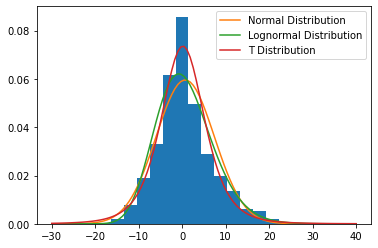

In [4]:
#Test Distributional fits to data
pos = "RB"
dist = distfit()
distribution_data = udfs_data.loc[udfs_data["Pos"] == pos]["error"]
dist.fit_transform(distribution_data)
dist_norm = distfit(distr=['norm'])
dist_log = distfit(distr=['lognorm'])
dist_t = distfit(distr=['t'])
results_norm = dist_norm.fit_transform(distribution_data)
results_log = dist_log.fit_transform(distribution_data)
results_t = dist_t.fit_transform(distribution_data)

#Plot distributions against histogram
plt.hist(distribution_data, 20, density=True)
pdf_x = np.linspace(-30, 40, num=100)
norm_pdf_y = stats.norm.pdf(pdf_x, results_norm["model"]["loc"], results_norm["model"]["scale"])
log_pdf_y = stats.lognorm.pdf(pdf_x, results_log["model"]["params"][0], results_log["model"]["loc"], results_log["model"]["scale"])
t_pdf_y = stats.t.pdf(pdf_x, results_t["model"]["params"][0], results_t["model"]["loc"], results_t["model"]["scale"])

plt.plot(pdf_x, norm_pdf_y, label = "Normal Distribution")
plt.plot(pdf_x, log_pdf_y, label = "Lognormal Distribution")
plt.plot(pdf_x, t_pdf_y, label = "T Distribution")
plt.legend(["Normal Distribution", "Lognormal Distribution", "T Distribution"])

In [5]:
#Generate data for same team correlation analysis
err_pairs = []
dk_data2 = udfs_data
pos1 = "QB"
pos2 = "WR"

for year in dk_data2["Year"].unique():
    for week in dk_data2["Week"].unique():
        for team in dk_data2.loc[(dk_data2["Year"] == year) & (dk_data2["Week"] == week)]["Team"].unique():
            err1_data = dk_data2.loc[(dk_data2["Year"] == year) & (dk_data2["Week"] == week) & (dk_data2["Team"] == team) & (dk_data2["Pos"] == pos1)]
            err2_data = dk_data2.loc[(dk_data2["Year"] == year) & (dk_data2["Week"] == week) & (dk_data2["Team"] == team) & (dk_data2["Pos"] == pos2)]
            for error1 in err1_data["error"]:
                for error2 in err2_data["error"]:
                    err_pairs.append((error1, error2))

[[60.57559863 15.00851471]
 [15.00851471 49.31383523]]
[[1.         0.27460249]
 [0.27460249 1.        ]]


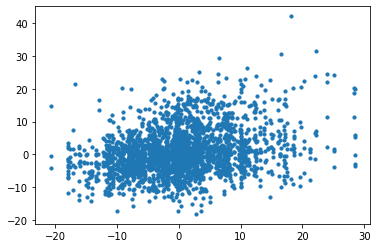

In [6]:
#Variance-Covariance and correlation
x = [err[0] for err in err_pairs]
y = [err[1] for err in err_pairs]
M = np.linalg.cholesky((np.linalg.inv(np.cov(x, y))))
plt.scatter(x,y, s=10)
print(np.cov(x, y))
print(np.corrcoef(x,y))

In [546]:
#Generate data for opposite team correlation analysis
err_pairs = []
pos = "DST"
oppt_pos = "DST"

for year in dk_data2["Year"].unique():
    for week in dk_data2["Week"].unique():
        for team in dk_data2.loc[(dk_data2["Year"] == year) & (dk_data2["Week"] == week)]["Team2"].unique():
            err1_data = dk_data2.loc[(dk_data2["Year"] == year) & (dk_data2["Week"] == week) & (dk_data2["Team2"] == team) & (dk_data2["Pos"] == pos)]
            try: 
                err2_data = dk_data2.loc[(dk_data2["Year"] == year) & (dk_data2["Week"] == week) & (dk_data2["Team2"] == err1_data["Oppt"].iloc[0]) & (dk_data2["Pos"] == oppt_pos)]
            except:
                print("Year: " + str(year) + "; Week: " + str(week) + "; Team: " + team)
            for error1 in err1_data["error"]:
                for error2 in err2_data["error"]:
                    err_pairs.append((error1, error2))


[[ 32.25557073 -10.19517366]
 [-10.19517366  32.78616263]]
[[ 1.        -0.3135068]
 [-0.3135068  1.       ]]


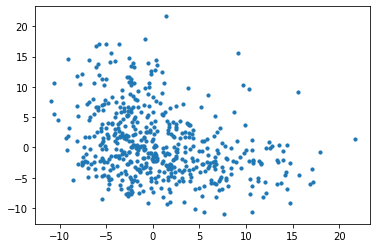

In [547]:
#Variance-Covariance and correlation
x = [err[0] for err in err_pairs]
y = [err[1] for err in err_pairs]
plt.scatter(x,y, s=10)
print(np.cov(x, y))
print(np.corrcoef(x,y))

(array([70.17157779, 39.08405058]), array([[ 0.8146029 , -0.58001906],
       [ 0.58001906,  0.8146029 ]]))


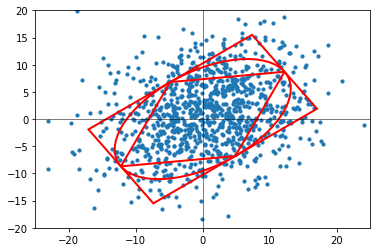

In [558]:
#Generate random data using measured mean and covariance
mean = [np.mean(x), np.mean(y)]
cov = np.cov(x, y)
rand_data = stats.multivariate_normal.rvs(mean, cov, 1000)

#Helper function for rotating points around the origin
def rotate(x, y, angle_rad):
    x_rot = x*math.cos(angle_rad) - y*math.sin(angle_rad)
    y_rot = y*math.cos(angle_rad) + x*math.sin(angle_rad)
    return [x_rot, y_rot]

#Extract rotation and scaling from covariance matrix using eigenvalues and eigenvectors 
transform = np.linalg.eig(cov)
rot = transform[1]
angle_rad = math.atan(rot[1, 0]/rot[0, 0])
angle = math.degrees(math.atan(rot[1, 0]/rot[0, 0]))
print(transform)

#Points for plotting shapes
width = 30
height = width*(transform[0][1]/transform[0][0])
poly_points = [rotate(width/2, 0, angle_rad), rotate(0, -height/2, angle_rad), rotate(-width/2, 0, angle_rad), rotate(0, height/2, angle_rad)]
rect_anc = rotate(-width/2, -height/2, angle_rad)

#Plotting data and shapes
fig, ax = plt.subplots()
ax.scatter(rand_data[:, 0], rand_data[:, 1], s=10)
ax.add_patch(Rectangle((rect_anc[0], rect_anc[1]), width, height, angle, edgecolor="red", fill=False, lw=2))
ax.add_patch(Ellipse((0, 0), width, height, angle, edgecolor="red", fill=False, lw=2))
ax.add_patch(Polygon(poly_points, edgecolor="red", fill=False, lw=2))
ax.axhline(color='black', lw=0.5)
ax.axvline(color='black', lw=0.5)
ax.set_xlim(-25, 25)
ax.set_ylim(-20, 20)
plt.show()